# XGBoost
The purpose of this notebook is to use XGBoost for predicting hourly bike demand by station.

In [2]:
# Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import datetime

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, accuracy_score, make_scorer, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel

from sklearn import datasets, svm

In [3]:
# Import data
df = pd.read_csv('data/bike_temp_fe.csv')
df['start_datetime'] = pd.to_datetime(df['start_datetime'])
df.head()

,num_trips,start_datetime,start_station_id,start_station_longitude,start_station_latitude,avg_trip_duration,num_trips_1hr,num_trips_2hr,num_trips_3hr,num_trips_4hr,...,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month_sin,month_cos,is_am_peak,is_pm_peak
0,0.0,2019-05-08,3183,-74.033459,40.716247,0.0,0.0,2.0,3.0,2.0,...,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,-0.974928,-0.222521,False,False
1,0.0,2019-05-08,3184,-74.033552,40.714145,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,-0.974928,-0.222521,False,False
2,0.0,2019-05-08,3185,-74.043845,40.717732,0.0,1.0,1.0,0.0,2.0,...,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,-0.974928,-0.222521,False,False
3,0.0,2019-05-08,3186,-74.043117,40.719586,0.0,0.0,4.0,8.0,8.0,...,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,-0.974928,-0.222521,False,False
4,0.0,2019-05-08,3187,-74.038051,40.721124,0.0,0.0,1.0,2.0,0.0,...,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,-0.974928,-0.222521,False,False


In [4]:
# Now drop the start_datetime column as we no longer need it
df.drop(columns=['start_datetime'], inplace=True)

In [5]:
df.head()

,num_trips,start_station_id,start_station_longitude,start_station_latitude,avg_trip_duration,num_trips_1hr,num_trips_2hr,num_trips_3hr,num_trips_4hr,num_trips_5hr,...,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month_sin,month_cos,is_am_peak,is_pm_peak
0,0.0,3183,-74.033459,40.716247,0.0,0.0,2.0,3.0,2.0,1.0,...,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,-0.974928,-0.222521,False,False
1,0.0,3184,-74.033552,40.714145,0.0,0.0,1.0,0.0,0.0,3.0,...,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,-0.974928,-0.222521,False,False
2,0.0,3185,-74.043845,40.717732,0.0,1.0,1.0,0.0,2.0,5.0,...,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,-0.974928,-0.222521,False,False
3,0.0,3186,-74.043117,40.719586,0.0,0.0,4.0,8.0,8.0,21.0,...,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,-0.974928,-0.222521,False,False
4,0.0,3187,-74.038051,40.721124,0.0,0.0,1.0,2.0,0.0,2.0,...,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,-0.974928,-0.222521,False,False


## Train XGBoost Model

In [6]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [7]:
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    
    return score

rmse_scorer = make_scorer(rmse, greater_is_better=False)

### Testing Train/Test Sizes

In [8]:
# Split data into X, y, and y_log
X = df.iloc[0:,1:]
y = df.iloc[:,0:1]

Because we are predicting bike demand in the future, we want to train data in the past and test data in the future. Let's test the model with different splits

In [12]:
# Create model
model = xgb.XGBRegressor()

# Test model for different splits
# The test sizes represent approximately 1 week, 2 weeks, and 3 weeks
test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for test_size in test_sizes:
    print(f"TEST SIZE: {test_size}", )
    # Test/train for that split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    # For non-scaled counts
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("RMSE for predicting counts: %f" % (rmse))

TEST SIZE: 0.1
RMSE for predicting counts: 1.383018
TEST SIZE: 0.2
RMSE for predicting counts: 1.336763
TEST SIZE: 0.3
RMSE for predicting counts: 1.285032
TEST SIZE: 0.4
RMSE for predicting counts: 1.343272
TEST SIZE: 0.5
RMSE for predicting counts: 1.329759
TEST SIZE: 0.6
RMSE for predicting counts: 1.301020
TEST SIZE: 0.7
RMSE for predicting counts: 1.628547
TEST SIZE: 0.8
RMSE for predicting counts: 1.464753
TEST SIZE: 0.9
RMSE for predicting counts: 1.436200


It appears the best training/test split is 70/30, as that results in the lowest RMSE.

In [9]:
best_split = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_split, shuffle=False)

In [39]:
pd.set_option('display.max_columns', None)
X_test

,start_station_id,start_station_longitude,start_station_latitude,avg_trip_duration,num_trips_1hr,num_trips_2hr,num_trips_3hr,num_trips_4hr,num_trips_5hr,num_trips_6hr,num_trips_24hr,num_trips_48hr,num_trips_week,day_of_week,day_of_month,month,hour,is_weekend,avg_daily_wind_speed,precipitation,snowfall,snow_depth,temp_max,temp_min,fog,heavy_fog,thunder,haze,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month_sin,month_cos,is_am_peak,is_pm_peak
75684,3183,-74.033459,40.716247,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,6,7,12,False,3.36,0.00,0.0,0.0,90,76,False,False,True,False,-1.361666e-01,-0.990686,-0.866025,0.5,9.377521e-01,0.347305,-2.449294e-16,1.0,False,False
75685,3184,-74.033552,40.714145,0.00,0.0,0.0,0.0,2.0,0.0,0.0,5.0,2.0,3.0,5,6,7,12,False,3.36,0.00,0.0,0.0,90,76,False,False,True,False,-1.361666e-01,-0.990686,-0.866025,0.5,9.377521e-01,0.347305,-2.449294e-16,1.0,False,False
75686,3185,-74.043845,40.717732,709.75,2.0,2.0,1.0,2.0,1.0,0.0,1.0,5.0,8.0,5,6,7,12,False,3.36,0.00,0.0,0.0,90,76,False,False,True,False,-1.361666e-01,-0.990686,-0.866025,0.5,9.377521e-01,0.347305,-2.449294e-16,1.0,False,False
75687,3186,-74.043117,40.719586,974.50,1.0,4.0,3.0,3.0,0.0,0.0,3.0,4.0,8.0,5,6,7,12,False,3.36,0.00,0.0,0.0,90,76,False,False,True,False,-1.361666e-01,-0.990686,-0.866025,0.5,9.377521e-01,0.347305,-2.449294e-16,1.0,False,False
75688,3187,-74.038051,40.721124,349.00,5.0,3.0,1.0,2.0,0.0,0.0,4.0,4.0,3.0,5,6,7,12,False,3.36,0.00,0.0,0.0,90,76,False,False,True,False,-1.361666e-01,-0.990686,-0.866025,0.5,9.377521e-01,0.347305,-2.449294e-16,1.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108115,3679,-74.071455,40.722104,0.00,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,2,31,7,23,True,2.91,0.36,0.0,0.0,87,70,True,False,True,False,-2.449294e-16,1.000000,0.866025,-0.5,-2.449294e-16,1.000000,-2.449294e-16,1.0,False,False
108116,3681,-74.037683,40.715178,673.00,1.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,2,31,7,23,True,2.91,0.36,0.0,0.0,87,70,True,False,True,False,-2.449294e-16,1.000000,0.866025,-0.5,-2.449294e-16,1.000000,-2.449294e-16,1.0,False,False
108117,3694,-74.078900,40.711130,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2,31,7,23,True,2.91,0.36,0.0,0.0,87,70,True,False,True,False,-2.449294e-16,1.000000,0.866025,-0.5,-2.449294e-16,1.000000,-2.449294e-16,1.0,False,False
108118,3791,-74.046964,40.735208,0.00,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,2,31,7,23,True,2.91,0.36,0.0,0.0,87,70,True,False,True,False,-2.449294e-16,1.000000,0.866025,-0.5,-2.449294e-16,1.000000,-2.449294e-16,1.0,False,False


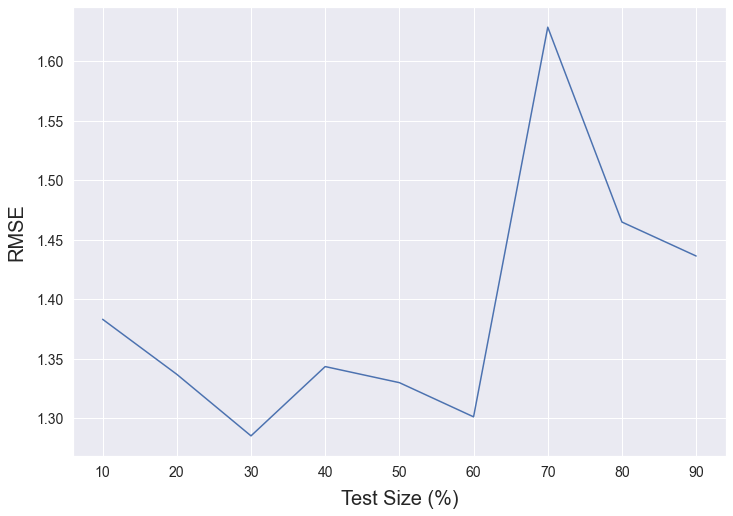

In [25]:
data = {
    'test_size': [10, 20, 30, 40, 50, 60, 70, 80, 90],
    'RMSE': [1.383018, 1.336763, 1.285032, 1.343272, 1.329759, 1.301020, 1.628547, 1.464753, 1.436200]
}
test_size_RMSE = pd.DataFrame(data)

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
p = sns.lineplot(data=test_size_RMSE, x='test_size', y='RMSE')
p.set_xlabel('Test Size (%)', fontsize=20, labelpad=10)
p.set_ylabel('RMSE', fontsize=20, labelpad=10)
p.tick_params(labelsize=14)

fig = p.get_figure()
fig.savefig('figs/XGBoost-TestSizevsRMSE.png', bbox_inches='tight')

### Testing k for k-fold validation

In [12]:
# Test out values of k
xgbGridCV = xgb.XGBRegressor()

k_values = [2, 4, 6, 8, 10, 12, 14]
for k in k_values:
    parameters = {
        'max_depth': [6],
        'min_child_weight': [5],
        'n_estimators' : [500],
        'learning_rate' : [0.2],
        'subsample': [0.8],
        'colsample_bytree': [1.0]
    }
    cv = GridSearchCV(xgbGridCV, parameters, cv=k, scoring=rmse_scorer)
    cv.fit(X_train, y_train.values.ravel())

    print(f"K VALUE: {k}", )
    print_results(cv)
    print("\n\n")

K VALUE: 2
BEST PARAMS: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8}

-1.263 (+/-0.078) for {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8}



K VALUE: 4
BEST PARAMS: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8}

-1.234 (+/-0.17) for {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8}



K VALUE: 6
BEST PARAMS: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8}

-1.227 (+/-0.236) for {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8}



K VALUE: 8
BEST PARAMS: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 6, 'min_ch

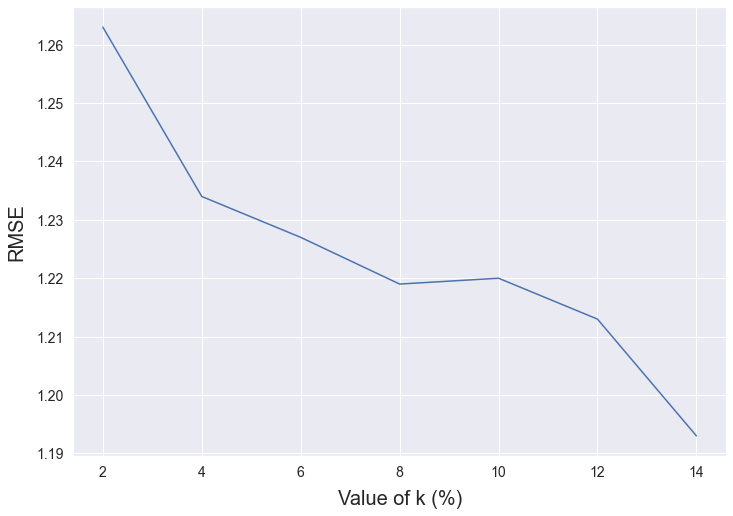

In [3]:
data = {
    'k_value': [2, 4, 6, 8, 10, 12, 14],
    'RMSE': [1.263, 1.234, 1.227, 1.219, 1.220, 1.213, 1.193]
}
k_value_RMSE = pd.DataFrame(data)

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
p = sns.lineplot(data=k_value_RMSE, x='k_value', y='RMSE')
p.set_xlabel('Value of k (%)', fontsize=20, labelpad=10)
p.set_ylabel('RMSE', fontsize=20, labelpad=10)
p.tick_params(labelsize=14)

fig = p.get_figure()
fig.savefig('figs/XGBoost-kvsRMSE.png', bbox_inches='tight')

### Feature Importance

Test features to use in the non-transformed counts model

In [17]:
model = xgb.XGBRegressor()
best_split = 0.3

# Counts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_split, shuffle=False)
model.fit(X_train, y_train)
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))

thresholds = np.sort(model.feature_importances_)
for thresh in thresholds:
    # select features above threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = xgb.XGBRegressor()
    selection_model.fit(select_X_train, y_train)
    # evaluate model
    select_X_test = selection.transform(X_test)
    preds = selection_model.predict(select_X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("Thresh=%.3f, n=%d, RMSE: %lf" % (thresh, select_X_train.shape[1], rmse))

# Transformed Count
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_split, shuffle=False)

Thresh=0.000, n=38, RMSE: 1.285032
Thresh=0.000, n=38, RMSE: 1.285032
Thresh=0.000, n=38, RMSE: 1.285032
Thresh=0.000, n=38, RMSE: 1.285032
Thresh=0.000, n=38, RMSE: 1.285032
Thresh=0.000, n=38, RMSE: 1.285032
Thresh=0.006, n=32, RMSE: 1.285032
Thresh=0.007, n=31, RMSE: 1.276124
Thresh=0.008, n=30, RMSE: 1.286696
Thresh=0.008, n=29, RMSE: 1.279341
Thresh=0.008, n=28, RMSE: 1.308608
Thresh=0.009, n=27, RMSE: 1.270327
Thresh=0.009, n=26, RMSE: 1.288639
Thresh=0.009, n=25, RMSE: 1.286952
Thresh=0.010, n=24, RMSE: 1.292506
Thresh=0.011, n=23, RMSE: 1.289915
Thresh=0.011, n=22, RMSE: 1.294190
Thresh=0.012, n=21, RMSE: 1.332223
Thresh=0.012, n=20, RMSE: 1.337455
Thresh=0.013, n=19, RMSE: 1.349190
Thresh=0.013, n=18, RMSE: 1.336798
Thresh=0.014, n=17, RMSE: 1.351457
Thresh=0.014, n=16, RMSE: 1.359478
Thresh=0.015, n=15, RMSE: 1.340271
Thresh=0.016, n=14, RMSE: 1.336837
Thresh=0.017, n=13, RMSE: 1.343129
Thresh=0.018, n=12, RMSE: 1.347250
Thresh=0.018, n=11, RMSE: 1.352887
Thresh=0.020, n=10, 

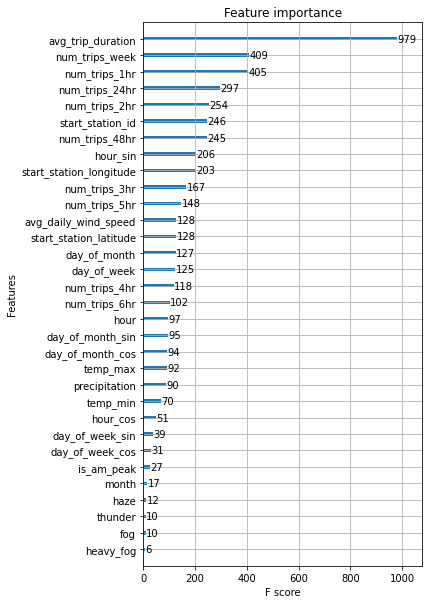

In [18]:
ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(5, 10)

Average trip duration and the number of trips in past time steps appear to have the biggest impact. The RMSE is only slightly reduced when including all factors; thus, lets keep them in the model during training.

In [9]:
# Split data into X and y
best_split = 0.3
X = df.iloc[0:,1:]
y = df.iloc[:,0:1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_split, shuffle=False)

### Hyperparameter Tuning

#### max_depth, min_child_weight

In [10]:
# Train max_depth and min_child_weight
# These parameters add constraints on the architectures of the trees, and should be trained together
xgbGridCV = xgb.XGBRegressor()

# max_depth: max number of nodes allowed from root to leaf
# Too large a depth can overfit
# min_child_weight: minimum weight required to create a new node in the tree
# smaller values allow for children to be created with fewer samples
parameters = {
    'max_depth' : [3, 6, 9],
    'min_child_weight' : [1, 3, 5, 7],
}

# Using cross validation in training sets
cv = GridSearchCV(xgbGridCV, parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train.values.ravel())

print_results(cv)

BEST PARAMS: {'max_depth': 6, 'min_child_weight': 7}

-1.213 (+/-0.12) for {'max_depth': 3, 'min_child_weight': 1}
-1.217 (+/-0.142) for {'max_depth': 3, 'min_child_weight': 3}
-1.213 (+/-0.131) for {'max_depth': 3, 'min_child_weight': 5}
-1.22 (+/-0.099) for {'max_depth': 3, 'min_child_weight': 7}
-1.222 (+/-0.202) for {'max_depth': 6, 'min_child_weight': 1}
-1.22 (+/-0.155) for {'max_depth': 6, 'min_child_weight': 3}
-1.221 (+/-0.189) for {'max_depth': 6, 'min_child_weight': 5}
-1.205 (+/-0.168) for {'max_depth': 6, 'min_child_weight': 7}
-1.263 (+/-0.178) for {'max_depth': 9, 'min_child_weight': 1}
-1.244 (+/-0.171) for {'max_depth': 9, 'min_child_weight': 3}
-1.25 (+/-0.181) for {'max_depth': 9, 'min_child_weight': 5}
-1.23 (+/-0.155) for {'max_depth': 9, 'min_child_weight': 7}


max_depth of 6 and min_child_weight of 7 resulted in the lowest RMSE.

#### n_estimators, learning_rate

In [13]:
# Now train n_estimators and learning_rate together

# learning_rate
# weighting factor for the corrections by new trees when adding to the model
# values < 1 has effect of making less corrections for each tree added to the model
# this in turn results in more trees that must be added to the model

# n_estimators
# the number of decision trees

parameters = {
    'max_depth': [6],
    'min_child_weight': [7],
    'n_estimators' : [10, 25, 50, 100, 200, 400, 500],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
}

# Using cross validation in training sets
cv = GridSearchCV(xgbGridCV, parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train.values.ravel())

print_results(cv)

BEST PARAMS: {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500}

-2.384 (+/-0.203) for {'learning_rate': 0.0001, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 10}
-2.381 (+/-0.203) for {'learning_rate': 0.0001, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 25}
-2.377 (+/-0.203) for {'learning_rate': 0.0001, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 50}
-2.369 (+/-0.202) for {'learning_rate': 0.0001, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100}
-2.353 (+/-0.2) for {'learning_rate': 0.0001, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 200}
-2.322 (+/-0.196) for {'learning_rate': 0.0001, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 400}
-2.306 (+/-0.194) for {'learning_rate': 0.0001, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500}
-2.369 (+/-0.202) for {'learning_rate': 0.001, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 10}
-2.345 (+/-0.199) for {'learning_rate': 0.001

learning_rate of 0.01 and n_estimators of 500 resulted in the lowest RMSE.

#### subsample

In [15]:
# Now train subsample - 
# these control the sampling of the dataset that is done at each boosting round
# They make it less likely to overfit to a single sample or feature
# subsample - fraction of observations to subsample at each step
xgbGridCV = xgb.XGBRegressor()
parameters = {
    'max_depth': [6],
    'min_child_weight': [7],
    'n_estimators' : [500],
    'learning_rate' : [0.01],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

# Using cross validation in training sets
cv = GridSearchCV(xgbGridCV, parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train.values.ravel())

print_results(cv)

BEST PARAMS: {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500, 'subsample': 0.8}

-1.193 (+/-0.126) for {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500, 'subsample': 0.5}
-1.192 (+/-0.123) for {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500, 'subsample': 0.6}
-1.186 (+/-0.118) for {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500, 'subsample': 0.7}
-1.184 (+/-0.122) for {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500, 'subsample': 0.8}
-1.187 (+/-0.126) for {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500, 'subsample': 0.9}
-1.19 (+/-0.13) for {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500, 'subsample': 1.0}


subsample of 0.8 resulted in the lowest RMSE.

#### colsample_bytree

In [17]:
# Now train colsample_bytree - 
# these control the sampling of the dataset that is done at each boosting round
# They make it less likely to overfit to a single sample or feature
# colsample_bytree - fraction of features (the columns) to use

xgbGridCV = xgb.XGBRegressor()
parameters = {
    'max_depth': [6],
    'min_child_weight': [7],
    'n_estimators' : [500],
    'learning_rate' : [0.01],
    'subsample': [0.8],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

# Using cross validation in training sets
cv = GridSearchCV(xgbGridCV, parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train.values.ravel())

print_results(cv)

BEST PARAMS: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500, 'subsample': 0.8}

-1.17 (+/-0.135) for {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500, 'subsample': 0.8}
-1.172 (+/-0.126) for {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500, 'subsample': 0.8}
-1.179 (+/-0.12) for {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500, 'subsample': 0.8}
-1.181 (+/-0.116) for {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500, 'subsample': 0.8}
-1.183 (+/-0.119) for {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500, 'subsample': 0.8}
-1.184 (+/-0.122) for {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_est

colsample_bytree of 0.5 resulted in the lowest RMSE.

#### Final Model

In [10]:
# Now lets run the model with only the best parameters
xgbGridCV = xgb.XGBRegressor()
parameters = {
    'max_depth': [6],
    'min_child_weight': [5],
    'n_estimators' : [500],
    'learning_rate' : [0.2],
    'subsample': [0.8],
    'colsample_bytree': [0.5]
}

# Using cross validation in training sets
cv = GridSearchCV(xgbGridCV, parameters, cv=14, scoring=rmse_scorer)
cv.fit(X_train, y_train.values.ravel())

print_results(cv)

BEST PARAMS: {'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8}

-1.193 (+/-0.281) for {'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8}


## Results

### Error (RMSE, MAE, R2)

In [11]:
# Now make predictions based on this model and compare to y_test
preds = cv.best_estimator_.predict(X_test)
# Make any negative predictions 0
preds[preds < 0] = 0

# Determine RMSE, MAE, R2
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
R2 = r2_score(y_test, preds)
print(f"RMSE of preds, y_test: {rmse}")
print(f"MAE of preds, y_test: {mae}")
print(f"R-Squared of preds, y_test: {R2}")

RMSE of preds, y_test: 1.3108225525481625
MAE of preds, y_test: 0.5219556725680433
R-Squared of preds, y_test: 0.7539123091915735


### Plot Actual vs. Predicted

In [12]:
# Combine X_test, y_test, preds
combined_df = pd.concat([X_test, y_test], axis=1)
combined_df['preds'] = preds
combined_df.head()

,start_station_id,start_station_longitude,start_station_latitude,avg_trip_duration,num_trips_1hr,num_trips_2hr,num_trips_3hr,num_trips_4hr,num_trips_5hr,num_trips_6hr,...,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month_sin,month_cos,is_am_peak,is_pm_peak,num_trips,preds
75684,3183,-74.033459,40.716247,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.866025,0.5,0.937752,0.347305,-2.449294e-16,1.0,False,False,0.0,0.283144
75685,3184,-74.033552,40.714145,0.00,0.0,0.0,0.0,2.0,0.0,0.0,...,-0.866025,0.5,0.937752,0.347305,-2.449294e-16,1.0,False,False,0.0,0.000000
75686,3185,-74.043845,40.717732,709.75,2.0,2.0,1.0,2.0,1.0,0.0,...,-0.866025,0.5,0.937752,0.347305,-2.449294e-16,1.0,False,False,4.0,6.795218
75687,3186,-74.043117,40.719586,974.50,1.0,4.0,3.0,3.0,0.0,0.0,...,-0.866025,0.5,0.937752,0.347305,-2.449294e-16,1.0,False,False,4.0,7.180532
75688,3187,-74.038051,40.721124,349.00,5.0,3.0,1.0,2.0,0.0,0.0,...,-0.866025,0.5,0.937752,0.347305,-2.449294e-16,1.0,False,False,1.0,2.873776


In [13]:
# Find max station, median station
sum_trips_df = df.groupby(['start_station_id'])['num_trips'].sum()

min_trips = sum_trips_df.min()
first_quart_trips = sum_trips_df.quantile(0.25, interpolation='nearest')
median_trips = sum_trips_df.median()
third_quart_trips = sum_trips_df.quantile(0.75, interpolation='nearest')
max_trips = sum_trips_df.max()


min_station = sum_trips_df[sum_trips_df == min_trips].index[0]
first_quart_station = sum_trips_df[sum_trips_df == first_quart_trips].index[0]
median_station = sum_trips_df[sum_trips_df == median_trips].index[0]
third_quart_station = sum_trips_df[sum_trips_df == third_quart_trips].index[0]
max_station = sum_trips_df[sum_trips_df == max_trips].index[0]

In [18]:
print("Station: trips")
print(f"{min_station}: {min_trips}")
print(f"{first_quart_station}: {first_quart_trips}")
print(f"{median_station}: {median_trips}")
print(f"{third_quart_station}: {third_quart_trips}")
print(f"{max_station}: {max_trips}")

Station: trips
3426: 13.0
3268: 855.0
3194: 1685.0
3187: 2750.0
3186: 12477.0


In [14]:
# Get max/median station values
min_station_df = combined_df.loc[df['start_station_id'] == min_station]
max_station_df = combined_df.loc[df['start_station_id'] == max_station]
median_station_df = combined_df.loc[df['start_station_id'] == median_station]

In [15]:
# Join max/median station with original df to get original datetimes
bike_df = pd.read_csv('data/bike_temp_clean.csv')
min_station_df = min_station_df.merge(bike_df)
median_station_df = median_station_df.merge(bike_df)
max_station_df = max_station_df.merge(bike_df)

#### Minimum Station

<AxesSubplot:xlabel='start_datetime'>

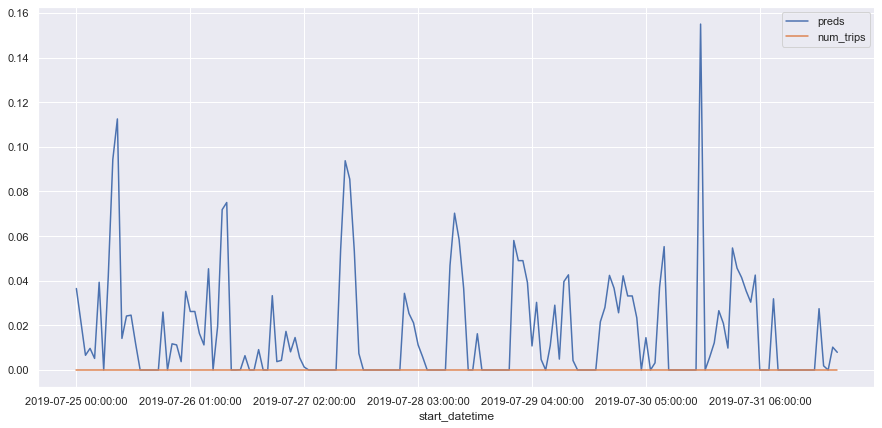

In [21]:
# Plot of max_station
min_station_df.tail(168).plot(x='start_datetime', y=['preds', 'num_trips'], figsize=(15,7))

#### Median Station

In [16]:
median_station_df.rename(columns={"num_trips": "Actual", "preds": "Predicted"}, inplace=True)

In [17]:
median_station_df['start_datetime'] = pd.to_datetime(median_station_df['start_datetime'])

In [18]:
df_plot = median_station_df.tail(168)[["start_datetime", "Actual", "Predicted"]]

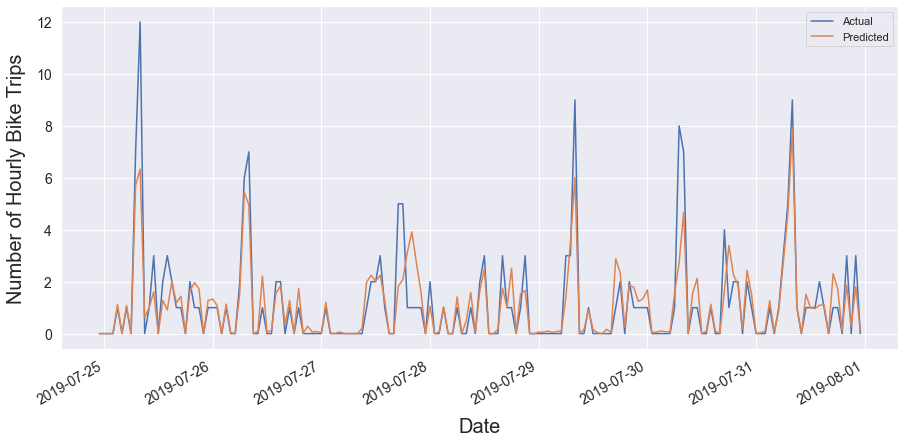

In [29]:
# Plot of median_station
sns.set_style("white")
sns.set(rc={'figure.figsize':(11.7,8.27)})
p = median_station_df.tail(168).plot(x='start_datetime', y=['Actual', 'Predicted'], figsize=(15,7))
p.set_xlabel('Date', fontsize=20, labelpad=10)
p.set_ylabel('Number of Hourly Bike Trips', fontsize=20, labelpad=10)
p.tick_params(labelsize=14)

fig = p.get_figure()
fig.savefig('figs/XGBoost-median.png', bbox_inches='tight')

#### Max Station

<AxesSubplot:xlabel='start_datetime'>

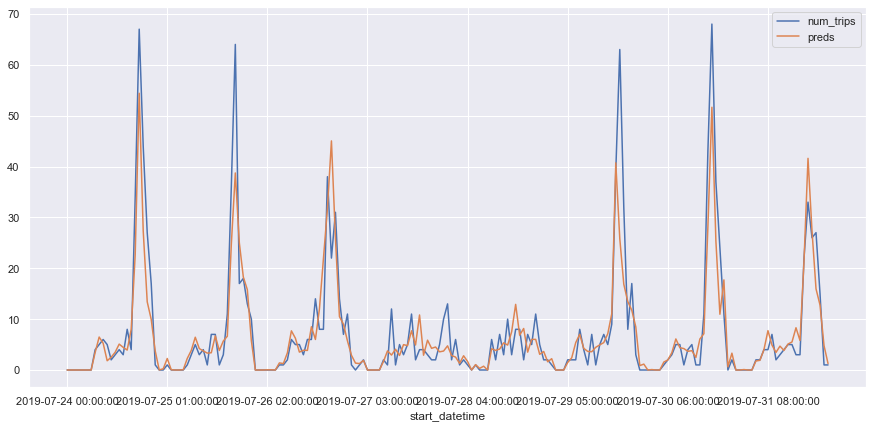

In [51]:
# Plot of median_station
max_station_df.plot(x='start_datetime', y=['num_trips', 'preds'], figsize=(15,7))

### Plot Distribution of Absolute Errors

In [19]:
# Determine absolute errors
combined_df['abs_error'] = np.absolute(combined_df['num_trips'] - combined_df['preds'])

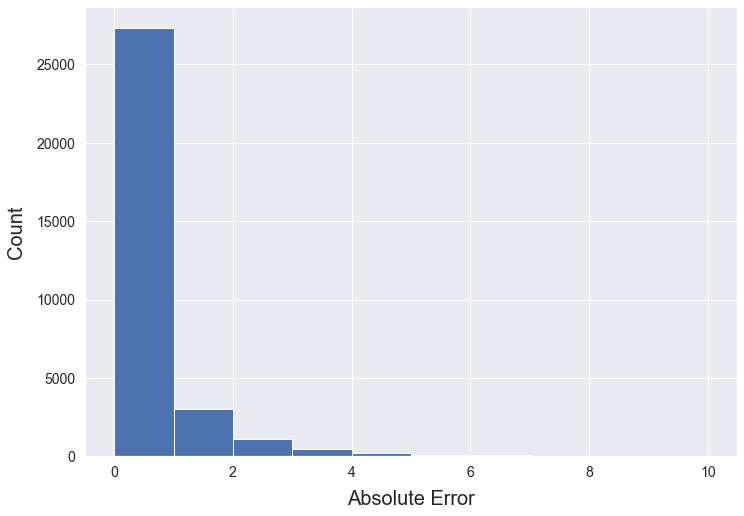

In [33]:
# Plot distribution
plt.hist(combined_df['abs_error'], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xlabel('Absolute Error', fontsize=20, labelpad=10)
plt.ylabel('Count', fontsize=20, labelpad=10)
plt.tick_params(labelsize=14)

plt.savefig('figs/XGBoost_AbsErrorHist.png', bbox_inches='tight')

In [22]:
y_test['preds'] = preds.reshape(-1, 1)
error_df = pd.DataFrame(np.abs(y_test['preds'] - y_test['num_trips']), columns=['abs_error']

/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
# Determine number of predictions with absolute error over 5
error_df[error_df['abs_error'] > 5].count()

abs_error    361
dtype: int64

In [31]:
# Determine number of predictions with absolute error over 10
error_df[error_df['abs_error'] > 10].count()

abs_error    69
dtype: int64

In [32]:
# Determine number of predictions with absolute error over 20
error_df[error_df['abs_error'] > 20].count()

abs_error    12
dtype: int64